<a href="https://colab.research.google.com/github/SoniaAndrys/stat/blob/master/LogL_unbinned_JustynaAndrys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

extremum found for mus =  21.523926072916986
-sigma = 14.054,  +sigma = 29.349


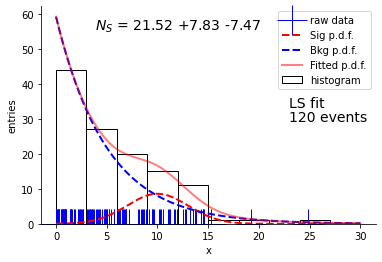

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import collections as collections
from scipy import stats
from scipy import special
from scipy import integrate
from scipy import optimize

#  Template for the ML fit to data

def gauss(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))


def decay(x, tau):
    return np.exp(-x/tau) / tau


def logL(mus, data, xmin=0, xmax=99, tau0=5.0, mu0=10.0, sigma0=3.0):
    # Find the p.d.f. normalisation factors for the considered interval (0, xrange) 
    integrals = integrate.quad(gauss, xmin, xmax, args=(mu0, sigma0))
    #print('integrals = ', integrals[0])
    scales = 1/integrals[0]
    integralb = integrate.quad(decay, xmin, xmax, args=(tau0,))
    #print('integralb = ', integralb[0])
    scaleb = 1/integralb[0]

    N = len(data)
    mub = N - mus
    # using first part of eq. 4 from lecture 5th
    temp_ll = -mus - mub

    for x in data:
        # normalized pdfs for signal and background 
        pdf_s = scales * gauss(x, mu0, sigma0)
        pdf_b = scaleb * decay(x, tau0)
        # using second part of eq.4 from lecture 5th  
        temp_ll += np.log(mus * pdf_s + mub * pdf_b)
    return -temp_ll


# Define known constants
tau = 5.0
mu = 10.0
sigma = 3.0

# Define some auxiliary parameters 
plow = 0.0
phig = 40.0
ndistr = 1000

# Deafine the histogram
nbins = 10
xrange = 30


x = np.linspace(0, xrange, ndistr)

# Load the raw data from file:
rndy = np.load("raw_data_1_tau5.npy")
nhist = len(rndy)

# Find the p.d.f. normalisation factors for the considered interval (0, xrange) 
integrals = integrate.quad(gauss, 0, xrange, args=(mu, sigma))
#print('integrals = ', integrals[0])
scales = 1/integrals[0]
integralb = integrate.quad(decay, 0, xrange, args=(tau,))
#print('integralb = ', integralb[0])
scaleb = 1/integralb[0]

# Histogram the raw data
hy, binsy = np.histogram(rndy, bins=nbins, range=(0.0, xrange) )

# Find the extremum of either logL or chi2
in_guess = [0,]
minimum = optimize.minimize(logL, in_guess, args=(rndy ,0.0, xrange, tau, mu, sigma))
fitted_mus = minimum.x[0]
print('extremum found for mus = ',fitted_mus)

#  Estimate the error:
pl = np.linspace(plow, phig, ndistr)
ll_array = []
for xx in pl:
   ll_array.append(logL(xx, rndy, 0.0, xrange, tau, mu, sigma))

ll_min_index = np.argmin(ll_array)
ll_min = ll_array[ll_min_index]

# Find index of element in array closest to value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

value = ll_min + 0.5
# Search to the left of ll_min
sigma_neg = pl[find_nearest(ll_array[:ll_min_index], value)]
# Search to the right of ll_min
sigma_pos = pl[find_nearest(ll_array[ll_min_index:], value) + ll_min_index]

#print(ll_min)
#print(value)
#print(logL(sigma_neg, rndy, 0.0, xrange, tau, mu, sigma))
#print(logL(sigma_pos, rndy, 0.0, xrange, tau, mu, sigma))

print("-sigma = %2.3f,  +sigma = %2.3f"%(sigma_neg, sigma_pos))



# fitted p.d.f.:
y = (fitted_mus/nhist*scales*gauss(x, mu, sigma)+(nhist-fitted_mus)/nhist*scaleb*decay(x, tau))
ys = (fitted_mus/nhist*scales*gauss(x, mu, sigma))
yb = ((nhist-fitted_mus)/nhist*scaleb*decay(x, tau))

fig, ax = plt.subplots()

ax.plot(rndy, np.zeros(rndy.shape), 'b+', ms=30, label="raw data")  # rug plot
ax.hist(rndy, bins=nbins, range=(0.0, xrange), fill=False, color='green', label="histogram")  # histogram

ax.plot(x, nhist*xrange*(1/nbins)*ys, 'r', linewidth=2, linestyle='--', label="Sig p.d.f.")
ax.plot(x, nhist*xrange*(1/nbins)*yb, 'b', linewidth=2, linestyle='--', label="Bkg p.d.f.")
ax.plot(x, nhist*xrange*(1/nbins)*y, 'r', alpha=0.5, linewidth=2, linestyle='-', label="Fitted p.d.f.")
#ax.set_ylim(bottom=0)

fig.text(0.70, 0.53, 'LS fit', fontsize=14)
fig.text(0.70, 0.48, '%d events'%nhist, fontsize=14)
fig.text(0.25, 0.80, '$N_S$ = %2.2f +%2.2f -%2.2f'%(fitted_mus,sigma_pos-fitted_mus,fitted_mus-sigma_neg), fontsize=14)
#fig.text(0.25, 0.80, '$N_S$ = %2.2f'%(fitted_mus), fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.legend(loc=1, fontsize=10)

ax.set_xlabel('x')
ax.set_ylabel('entries')

plt.show()